In [1]:
from matplotlib.colors import ListedColormap
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.metrics import auc,roc_curve, precision_recall_curve, roc_auc_score,confusion_matrix
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from collections import Counter
import glob
import os
import numpy as np
import cv2
from PIL import Image
from time import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets #手写数据集要用到
from sklearn.manifold import TSNE

with open("../../domain-generalization-for-anomaly-detection/config.yml", 'r', encoding="utf-8") as f:
    import yaml
    config = yaml.load(f.read(), Loader=yaml.FullLoader)
class_to_idx = config["PACS_class_to_idx"]
domain_to_idx = config["PACS_domain_to_idx"]

In [2]:
def calc_label_idx(domain, idx):
    return domain_to_idx[domain] * 7 + idx

for item in config["PACS_domain_to_idx"].keys():
    print(item, len(glob.glob(f'/home/hzw/DGAD/dataset/pacs_data/{item}/*/*.[jp][pn]g')))

print()
for item in config["PACS_class_to_idx"].keys():
    print(item, len(glob.glob(f'/home/hzw/DGAD/dataset/pacs_data/*/{item}/*.[jp][pn]g')))

art_painting 2048
cartoon 2344
photo 1670
sketch 3929

dog 1729
elephant 1654
giraffe 1566
guitar 1113
horse 1540
house 943
person 1446


In [16]:
image_path_list = []
class_list = []
domain_list = []
img_list = []
for domain_type in os.listdir("/home/hzw/DGAD/dataset/pacs_data"):
    for _class_ in os.listdir(f"/home/hzw/DGAD/dataset/pacs_data/{domain_type}"):
        for file_name in os.listdir(f"/home/hzw/DGAD/dataset/pacs_data/{domain_type}/{_class_}"):
            image_path = f"/home/hzw/DGAD/dataset/pacs_data/{domain_type}/{_class_}/{file_name}"
            img=cv2.imread(image_path)
            img_gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
            
            img_list.append(img_gray.flatten())
            image_path_list.append(image_path)
            class_list.append(class_to_idx[_class_])
            domain_list.append(domain_to_idx[domain_type])
img_list = np.array(img_list)

In [ ]:
perplexity=1427
early_exaggeration=12
tsne_2D = TSNE(n_components=2, init='pca', random_state=0, perplexity=perplexity, verbose=1, early_exaggeration=early_exaggeration) #调用TSNE
result_2D = tsne_2D.fit_transform(img_list)
np.savez(f'../results/t-SNE/perplexity={perplexity},early_exaggeration={early_exaggeration}.npz', result_2D = result_2D)

In [4]:
data = np.load("../results/t-SNE/perplexity=1747.npz", allow_pickle=True)
result_2D = data["result_2D"]

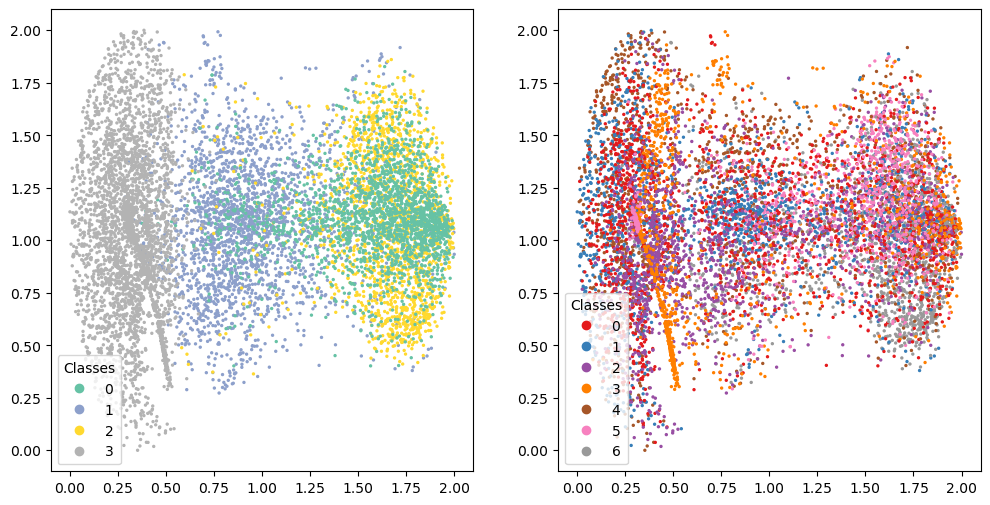

In [5]:
x_min, x_max = np.min(result_2D, 0), np.max(result_2D, 0)
data = (result_2D - x_min) / (x_max - x_min) * 2
fig, ax  = plt.subplots(1,2,figsize=(12, 6))
scatter = ax[0].scatter(data[:, 0], data[:, 1], c=domain_list, cmap=plt.cm.Set2, s=2)
ax[0].legend(*scatter.legend_elements(),loc="lower left", title="Classes")
# plt.legend()

scatter = ax[1].scatter(data[:, 0], data[:, 1], c=class_list, cmap=plt.cm.Set1, s=2)
ax[1].legend(*scatter.legend_elements(),loc="lower left", title="Classes")

In [6]:
normal_class="0"
anomaly_class="123456"
data = np.load(f'../../domain-generalization-for-anomaly-detection/data/three_source_domain/semi-supervised/20231228-PACS-{normal_class}-{anomaly_class}.npz', allow_pickle=True)
data

NpzFile '../../domain-generalization-for-anomaly-detection/data/three_source_domain/semi-supervised/20231228-PACS-0-123456.npz' with keys: train_set_path, train_labels, val_set_path, val_labels, test_photo...

In [7]:
data_dict = dict()
for item in ["test_photo", "test_cartoon", "test_art_painting", "test_sketch", "train_set_path"]:
    print(item)
    class_list = []
    domain_list = []
    img_list = []
    for file_path in data[item]:
        img=cv2.imread(f'../{config["PACS_root"]}{file_path}')
        img_gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        
        img_list.append(img_gray.flatten())
        domain_list.append(domain_to_idx[file_path.split("/")[2]])
        class_list.append(class_to_idx[file_path.split("/")[3]])
    
    img_list = np.array(img_list)
    class_list = np.array(class_list)
    domain_list = np.array(domain_list)
    print(Counter(class_list))
    print(Counter(domain_list))
    data_dict[item] = {
        "img_list":img_list,
        "class_list":class_list,
        "domain_list":domain_list,
    }

test_photo
Counter({6: 86, 5: 56, 1: 40, 4: 39, 0: 37, 3: 37, 2: 36})
Counter({2: 331})
test_cartoon
Counter({1: 91, 6: 81, 0: 77, 2: 69, 4: 64, 5: 57, 3: 27})
Counter({1: 466})
test_art_painting
Counter({6: 89, 0: 75, 5: 59, 2: 57, 1: 51, 4: 40, 3: 36})
Counter({0: 407})
test_sketch
Counter({4: 163, 0: 154, 2: 150, 1: 148, 3: 121, 6: 32, 5: 16})
Counter({3: 784})
train_set_path
Counter({0: 614, 5: 3, 6: 3, 2: 3, 1: 3, 4: 3, 3: 3})
Counter({1: 255, 0: 249, 2: 128})


In [14]:
selected_data = "test_photo"
selected_data = "test_cartoon"
selected_data = "test_art_painting"
selected_data = "test_sketch"
selected_data = "train_set_path"
perplexity=200
early_exaggeration=50
tsne_2D = TSNE(n_components=3, init='pca', random_state=0, perplexity=perplexity, verbose=1, early_exaggeration=early_exaggeration) #调用TSNE
result_2D = tsne_2D.fit_transform(data_dict[selected_data]["img_list"])
# np.savez(f'../results/t-SNE/perplexity={perplexity},early_exaggeration={early_exaggeration}.npz', result_2D = result_2D)

[t-SNE] Computing 601 nearest neighbors...
[t-SNE] Indexed 632 samples in 0.027s...
[t-SNE] Computed neighbors for 632 samples in 11.259s...
[t-SNE] Computed conditional probabilities for sample 632 / 632
[t-SNE] Mean sigma: 8522.596735
[t-SNE] KL divergence after 250 iterations with early exaggeration: 480.319489
[t-SNE] KL divergence after 1000 iterations: 1.702343


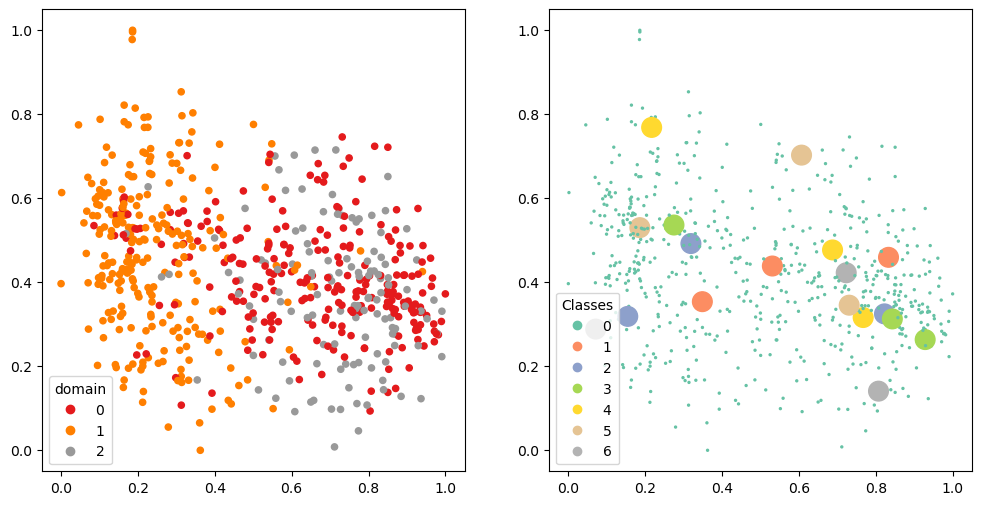

In [13]:
x_min, x_max = np.min(result_2D, 0), np.max(result_2D, 0)
data = (result_2D - x_min) / (x_max - x_min)
fig, ax  = plt.subplots(1,2,figsize=(12,6))

scatter = ax[0].scatter(data[:, 0], data[:, 1], c=data_dict[selected_data]["domain_list"], cmap=plt.cm.Set1, s=20)
ax[0].legend(*scatter.legend_elements(),loc="lower left", title="domain")

normale_idx = np.where(np.array(data_dict[selected_data]["class_list"]) == 0)[0]
anomaly_idx = np.where(np.array(data_dict[selected_data]["class_list"]) != 0)[0]
s_list = np.zeros_like(data_dict[selected_data]["class_list"])
s_list[normale_idx] = 2
s_list[anomaly_idx] = 200
scatter = ax[1].scatter(data[:, 0], data[:, 1], c=data_dict[selected_data]["class_list"], cmap=plt.cm.Set2, s=s_list)
ax[1].legend(*scatter.legend_elements(),loc="lower left", title="Classes")

In [ ]:
perplexity=200
early_exaggeration=12
tsne_2D = TSNE(n_components=3, init='pca', random_state=0, perplexity=perplexity, verbose=1, early_exaggeration=early_exaggeration) #调用TSNE
result_2D = tsne_2D.fit_transform(data_dict[selected_data]["img_list"])

In [67]:
intermediate_train = np.load('../results/intermediate_results/epoch=1.npz', allow_pickle=True)
intermediate_train

NpzFile '../results/intermediate_results/epoch=1.npz' with keys: domain_prototype, center, class_feature, texture_feature, total_pred...

In [68]:
[item for item in intermediate_train.keys()]

['domain_prototype',
 'center',
 'class_feature',
 'texture_feature',
 'total_pred',
 'total_target']

In [28]:
result = np.load('../results/DGAD/method6_lambda/method=6,backbone=DGAD6,domain_cnt=3,normal_class=[0],anomaly_class=[1, 2, 3, 4, 5, 6],batch_size=30,steps_per_epoch=20,epochs=30,lr=0.0001,tau1=0.07,tau2=0.07,reg_lambda=1.0,NCE_lambda=1.0,PL_lambda=2.0,cnt=0.npz', allow_pickle=True)

In [29]:
max_val_epoch = result["val_max_metric"].item()['epoch']
print(max_val_epoch)

1


In [52]:
for item in config["PACS_domain_to_idx"].keys():
    pred = result["test_results_list"][max_val_epoch][item]["pred"]
    target = result["test_results_list"][max_val_epoch][item]["target"]    

<Axes: ylabel='Density'>

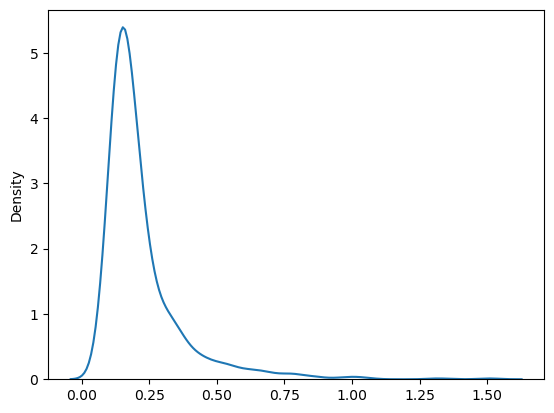

In [53]:
sns.kdeplot(pred)

In [54]:
precision, recall, threshold = precision_recall_curve(target, pred)

In [64]:
(2 * precision * recall / (precision + recall))

array([0.89108911, 0.89171975, 0.89093484, 0.89156627, 0.89078014,
       0.89141235, 0.890625  , 0.88983653, 0.89046942, 0.88967972,
       0.89031339, 0.88952245, 0.89015692, 0.89079229, 0.89      ,
       0.89063617, 0.88984263, 0.88904796, 0.88968481, 0.88888889,
       0.88809182, 0.88729361, 0.88793103, 0.88856937, 0.88776978,
       0.88696904, 0.88760807, 0.88824802, 0.88744589, 0.8866426 ,
       0.88583815, 0.88503254, 0.88567294, 0.88486604, 0.88405797,
       0.88469906, 0.8838897 , 0.88307916, 0.88372093, 0.88290909,
       0.88355167, 0.88419519, 0.88338192, 0.88402626, 0.88321168,
       0.88239591, 0.88157895, 0.88222385, 0.88140556, 0.88058608,
       0.8797654 , 0.87894351, 0.87958884, 0.87876561, 0.87794118,
       0.87711553, 0.87628866, 0.87693441, 0.87610619, 0.87675277,
       0.87592319, 0.87657058, 0.87573964, 0.87490748, 0.87407407,
       0.87323944, 0.87240356, 0.87156644, 0.87072808, 0.86988848,
       0.87053571, 0.86969471, 0.86885246, 0.86800895, 0.86716

In [42]:
roc_auc = roc_auc_score()
roc_auc

0.6809214594928881

In [66]:
[key for key in data.keys()]

['val_max_metric',
 'train_results_loss',
 'sub_train_results_loss',
 'val_results_loss',
 'val_AUROC_list',
 'val_AUPRC_list',
 'test_results_list',
 'test_metric',
 'args']

/home/hzw/anaconda3/envs/general_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/hzw/anaconda3/envs/general_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/hzw/anaconda3/envs/general_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/hzw/anaconda3/envs/general_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarni

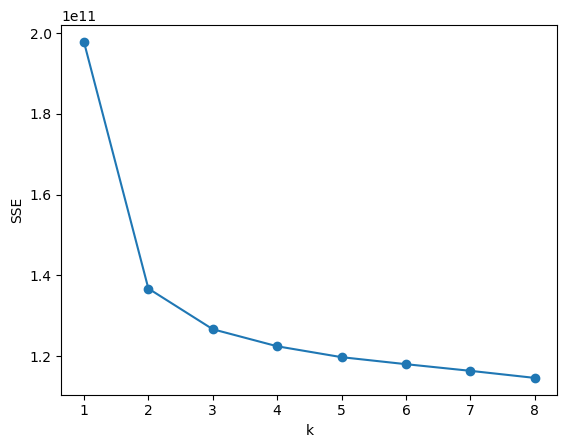

In [46]:
SSE = []  # 存放每次结果的误差平方和
for k in range(1,9):
    estimator = KMeans(n_clusters=k)  # 构造聚类器
    estimator.fit(img_list)
    SSE.append(estimator.inertia_) # estimator.inertia_获取聚类准则的总和
X = range(1,9)
plt.xlabel('k')
plt.ylabel('SSE')
plt.plot(X,SSE,'o-')
plt.show()

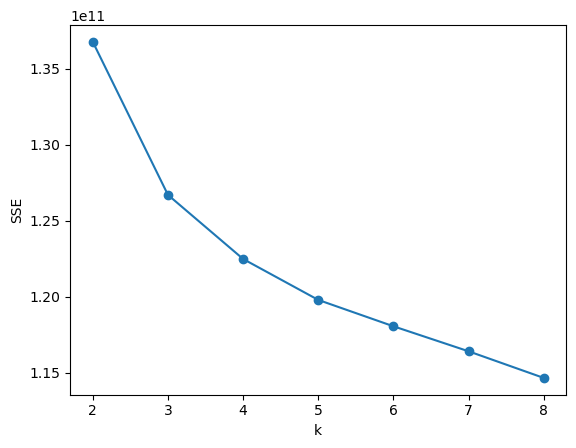

In [57]:
X = range(1,9)
plt.xlabel('k')
plt.ylabel('SSE')
plt.plot(X[1:],SSE[1:],'o-')
plt.show()

/home/hzw/anaconda3/envs/general_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/hzw/anaconda3/envs/general_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/hzw/anaconda3/envs/general_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/hzw/anaconda3/envs/general_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarni

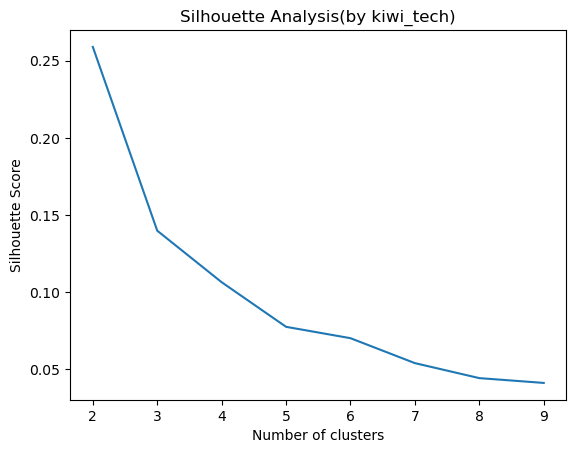

In [61]:
silhouette_scores = [] 
for i in range(2,10): 
    kmeans = KMeans(n_clusters=i) 
    kmeans.fit(img_list) 
    silhouette_scores.append(silhouette_score(img_list, kmeans.labels_)) 

# 绘制轮廓分析法图
plt.plot(range(2,10), silhouette_scores) 
plt.title( 'Silhouette Analysis(by kiwi_tech)' ) 
plt.xlabel( 'Number of clusters' ) 
plt.ylabel( 'Silhouette Score' ) 
plt.show()

## Train

In [ ]:
class_result_2D_list = []
domain_result_2D_list = []

selected_epochs = 10
for selected_epochs in range(30):
    intermediate_train = np.load(f'../results/intermediate_results/epoch={selected_epochs}.npz', allow_pickle=True)
    intermediate_train

    perplexity=300
    early_exaggeration=12
    tsne_2D = TSNE(n_components=2, init='pca', random_state=0, perplexity=perplexity, verbose=1, early_exaggeration=early_exaggeration) #调用TSNE
    class_result_2D = tsne_2D.fit_transform(np.concatenate([intermediate_train["class_feature"], intermediate_train["center"].reshape(1, -1)]))
    class_result_2D_list.append(class_result_2D)

    colors = ['#999999', '#e41a1c', '#ff7f00']
    custom_cmap = ListedColormap(colors)

    x_min, x_max = np.min(class_result_2D, 0), np.max(class_result_2D, 0)
    data = (class_result_2D - x_min) / (x_max - x_min)
    fig, ax  = plt.subplots(1,1,figsize=(6,6))

    size = np.zeros_like(intermediate_train["target_list"], dtype=int) + 20
    size = np.append(size, 100)
    scatter = ax.scatter(data[:, 0], data[:, 1], c=np.append(intermediate_train["target_list"], 2), cmap=custom_cmap, s=size)
    ax.legend(*(scatter.legend_elements()[0],["normal", "anomaly", "center"]))
    plt.savefig(f"../results/intermediate_results/epoch={selected_epochs},class_embedding.pdf", format="pdf")

    perplexity=200
    early_exaggeration=12
    tsne_2D = TSNE(n_components=2, init='pca', random_state=0, perplexity=perplexity, verbose=1, early_exaggeration=early_exaggeration) #调用TSNE
    domain_result_2D = tsne_2D.fit_transform(np.concatenate([intermediate_train["texture_feature"], intermediate_train["domain_prototype"]]))
    domain_result_2D_list.append(domain_result_2D)

    colors = ['#999999', '#e41a1c', '#ff7f00']
    custom_cmap = ListedColormap(colors)

    x_min, x_max = np.min(domain_result_2D, 0), np.max(domain_result_2D, 0)
    data = (domain_result_2D - x_min) / (x_max - x_min)
    fig, ax  = plt.subplots(1,1,figsize=(6,6))

    size = np.zeros_like(intermediate_train["target_list"], dtype=int) + 20
    size = np.concatenate([size, np.array([100, 100, 100])])
    scatter = ax.scatter(data[:, 0], data[:, 1], c=np.concatenate([intermediate_train["domain_label_list"], np.array([0,1,2])]), cmap=plt.cm.Set1, s=size)
    ax.legend(*(scatter.legend_elements()[0], ['art_painting', 'cartoon', 'photo', 'sketch']))
    plt.savefig(f"../results/intermediate_results/epoch={selected_epochs},domain_embedding.pdf", format="pdf")

np.savez('../results/intermediate_results/t-nse.npz',
         class_result_2D_list=np.array(class_result_2D_list),
         domain_result_2D_list=np.array(domain_result_2D_list),)

In [ ]:
np.savez('../results/intermediate_results/t-nse.npz',
         class_result_2D_list=np.array(class_result_2D_list),
         domain_result_2D_list=np.array(domain_result_2D_list),)

In [5]:
class_result_2D_list = []
domain_result_2D_list = []

In [32]:
selected_epochs = 0
intermediate_train = np.load(f'../results/intermediate_results/epoch={selected_epochs}.npz', allow_pickle=True)
intermediate_train

NpzFile '../results/intermediate_results/epoch=0.npz' with keys: domain_prototype, center, class_feature, texture_feature, target_list...

In [11]:
for item in intermediate_train.keys():
    print(item, intermediate_train[item].shape)

domain_prototype (3, 1000)
center (1000,)
class_feature (600, 1000)
texture_feature (600, 1000)
target_list (600,)
domain_label_list (600,)
total_pred (172,)
total_target (172,)


In [7]:
perplexity=300
early_exaggeration=12
tsne_2D = TSNE(n_components=2, init='pca', random_state=0, perplexity=perplexity, verbose=1, early_exaggeration=early_exaggeration) #调用TSNE
class_result_2D = tsne_2D.fit_transform(np.concatenate([intermediate_train["class_feature"], intermediate_train["center"].reshape(1, -1)]))

[t-SNE] Computing 600 nearest neighbors...
[t-SNE] Indexed 601 samples in 0.001s...
[t-SNE] Computed neighbors for 601 samples in 1.017s...
[t-SNE] Computed conditional probabilities for sample 601 / 601
[t-SNE] Mean sigma: 4.301159
[t-SNE] KL divergence after 100 iterations with early exaggeration: 35.689671
[t-SNE] KL divergence after 850 iterations: 0.180400


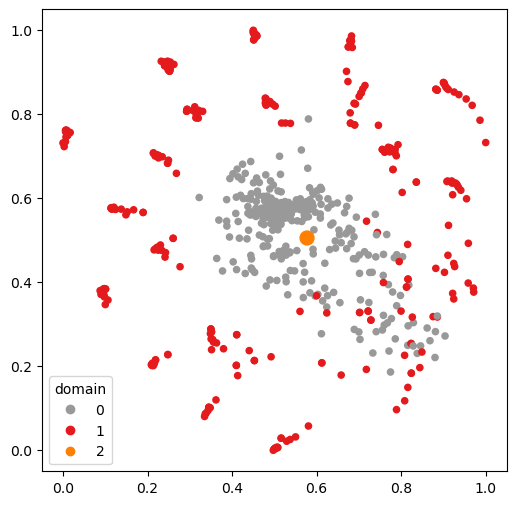

In [8]:
colors = ['#999999', '#e41a1c', '#ff7f00']
custom_cmap = ListedColormap(colors)

x_min, x_max = np.min(class_result_2D, 0), np.max(class_result_2D, 0)
data = (class_result_2D - x_min) / (x_max - x_min)
fig, ax  = plt.subplots(1,1,figsize=(6,6))

size = np.zeros_like(intermediate_train["target_list"], dtype=int) + 20
size = np.append(size, 100)
scatter = ax.scatter(data[:, 0], data[:, 1], c=np.append(intermediate_train["target_list"], 2), cmap=custom_cmap, s=size)
ax.legend(*(scatter.legend_elements()[0],["normal", "anomaly", "center"]))
plt.savefig(f"../results/intermediate_results/epoch={selected_epochs},class_embedding.pdf", format="pdf")

In [9]:
perplexity=200
early_exaggeration=12
tsne_2D = TSNE(n_components=2, init='pca', random_state=0, perplexity=perplexity, verbose=1, early_exaggeration=early_exaggeration) #调用TSNE
domain_result_2D = tsne_2D.fit_transform(np.concatenate([intermediate_train["texture_feature"], intermediate_train["domain_prototype"]]))

[t-SNE] Computing 601 nearest neighbors...
[t-SNE] Indexed 603 samples in 0.001s...
[t-SNE] Computed neighbors for 603 samples in 0.431s...
[t-SNE] Computed conditional probabilities for sample 603 / 603
[t-SNE] Mean sigma: 0.293297
[t-SNE] KL divergence after 100 iterations with early exaggeration: 41.851307
[t-SNE] KL divergence after 850 iterations: 0.117842


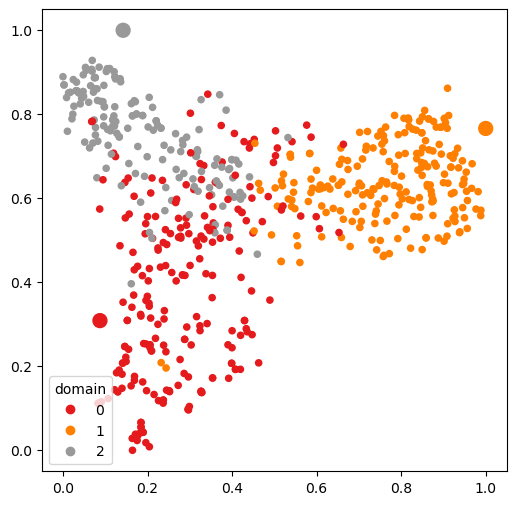

In [10]:
colors = ['#999999', '#e41a1c', '#ff7f00']
custom_cmap = ListedColormap(colors)

x_min, x_max = np.min(domain_result_2D, 0), np.max(domain_result_2D, 0)
data = (domain_result_2D - x_min) / (x_max - x_min)
fig, ax  = plt.subplots(1,1,figsize=(6,6))

size = np.zeros_like(intermediate_train["target_list"], dtype=int) + 20
size = np.concatenate([size, np.array([100, 100, 100])])
scatter = ax.scatter(data[:, 0], data[:, 1], c=np.concatenate([intermediate_train["domain_label_list"], np.array([0,1,2])]), cmap=plt.cm.Set1, s=size)
ax.legend(*(scatter.legend_elements()[0], ['art_painting', 'cartoon', 'photo']))
plt.savefig(f"../results/intermediate_results/epoch={selected_epochs},domain_embedding.pdf", format="pdf")

In [11]:
Counter(intermediate_train["domain_label_list"])

Counter({0: 224, 1: 218, 2: 158})

## val

In [27]:
selected_epochs = 0
intermediate_val = np.load(f'../results/intermediate_results/epoch={selected_epochs},val.npz', allow_pickle=True)
intermediate_val

NpzFile '../results/intermediate_results/epoch=0,val.npz' with keys: class_feature_list, texture_feature_list, target_list, domain_label_list, total_pred...

In [19]:
perplexity=150
early_exaggeration=12
tsne_2D = TSNE(n_components=2, init='pca', random_state=0, perplexity=perplexity, verbose=1, early_exaggeration=early_exaggeration) #调用TSNE
val_class_result_2D = tsne_2D.fit_transform(np.concatenate([intermediate_val["class_feature_list"], intermediate_train["center"].reshape(1, -1)]))

[t-SNE] Computing 172 nearest neighbors...
[t-SNE] Indexed 173 samples in 0.001s...
[t-SNE] Computed neighbors for 173 samples in 1.397s...
[t-SNE] Computed conditional probabilities for sample 173 / 173
[t-SNE] Mean sigma: 3.004643
[t-SNE] KL divergence after 250 iterations with early exaggeration: 34.028957
[t-SNE] KL divergence after 900 iterations: 0.028191


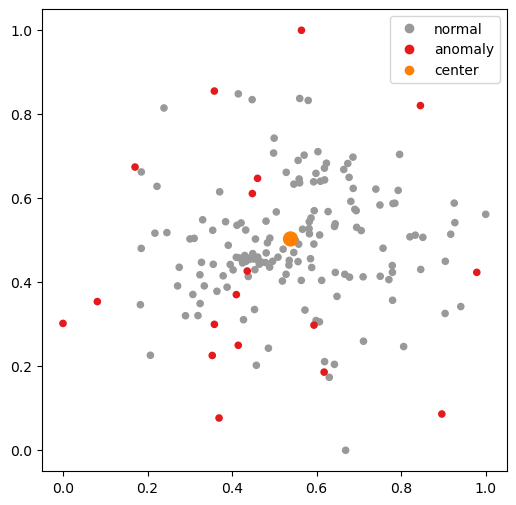

In [20]:
colors = ['#999999', '#e41a1c', '#ff7f00']
custom_cmap = ListedColormap(colors)

x_min, x_max = np.min(val_class_result_2D, 0), np.max(val_class_result_2D, 0)
data = (val_class_result_2D - x_min) / (x_max - x_min)
fig, ax  = plt.subplots(1,1,figsize=(6,6))

size = np.zeros_like(intermediate_val["target_list"], dtype=int) + 20
size = np.append(size, 100)
scatter = ax.scatter(data[:, 0], data[:, 1], c=np.append(intermediate_val["target_list"], 2), cmap=custom_cmap, s=size)
ax.legend(*(scatter.legend_elements()[0],["normal", "anomaly", "center"]))
plt.savefig(f"../results/intermediate_results/epoch={selected_epochs},val_class_embedding.pdf", format="pdf")

In [30]:
perplexity=60
early_exaggeration=12
tsne_2D = TSNE(n_components=2, init='pca', random_state=0, perplexity=perplexity, verbose=1, early_exaggeration=early_exaggeration) #调用TSNE
domain_result_2D = tsne_2D.fit_transform(np.concatenate([intermediate_val["texture_feature_list"], intermediate_train["domain_prototype"]]))

[t-SNE] Computing 174 nearest neighbors...
[t-SNE] Indexed 175 samples in 0.001s...


[t-SNE] Computed neighbors for 175 samples in 0.373s...
[t-SNE] Computed conditional probabilities for sample 175 / 175
[t-SNE] Mean sigma: 0.259027
[t-SNE] KL divergence after 250 iterations with early exaggeration: 41.236683
[t-SNE] KL divergence after 1000 iterations: 0.116050


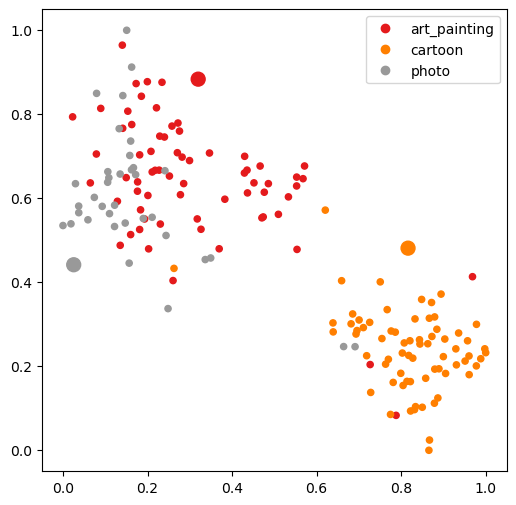

In [31]:
colors = ['#999999', '#e41a1c', '#ff7f00']
custom_cmap = ListedColormap(colors)

x_min, x_max = np.min(domain_result_2D, 0), np.max(domain_result_2D, 0)
data = (domain_result_2D - x_min) / (x_max - x_min)
fig, ax  = plt.subplots(1,1,figsize=(6,6))

size = np.zeros_like(intermediate_val["target_list"], dtype=int) + 20
size = np.concatenate([size, np.array([100, 100, 100])])
scatter = ax.scatter(data[:, 0], data[:, 1], c=np.concatenate([intermediate_val["domain_label_list"], np.array([0,1,2])]), cmap=plt.cm.Set1, s=size)
ax.legend(*(scatter.legend_elements()[0], ['art_painting', 'cartoon', 'photo']))
plt.savefig(f"../results/intermediate_results/epoch={selected_epochs},domain_embedding.pdf", format="pdf")

## Test

In [17]:
selected_epochs = 0
intermediate_test = dict()
for item in domain_to_idx.keys():
    intermediate_test[item] = np.load(f'../results/intermediate_results/epoch={selected_epochs},{item}.npz', allow_pickle=True)
intermediate_test

{'art_painting': NpzFile '../results/intermediate_results/epoch=0,art_painting.npz' with keys: class_feature_list, texture_feature_list, target_list, domain_label_list, total_pred...,
 'cartoon': NpzFile '../results/intermediate_results/epoch=0,cartoon.npz' with keys: class_feature_list, texture_feature_list, target_list, domain_label_list, total_pred...,
 'photo': NpzFile '../results/intermediate_results/epoch=0,photo.npz' with keys: class_feature_list, texture_feature_list, target_list, domain_label_list, total_pred...,
 'sketch': NpzFile '../results/intermediate_results/epoch=0,sketch.npz' with keys: class_feature_list, texture_feature_list, target_list, domain_label_list, total_pred...}

In [56]:
selected_domain = "photo"
[key for key in intermediate_test[selected_domain].keys()]

['class_feature_list',
 'texture_feature_list',
 'target_list',
 'domain_label_list',
 'total_pred',
 'AUROC',
 'AUPRC']

Counter({1: 332, 0: 75})
[t-SNE] Computing 407 nearest neighbors...
[t-SNE] Indexed 408 samples in 0.001s...
[t-SNE] Computed neighbors for 408 samples in 0.318s...
[t-SNE] Computed conditional probabilities for sample 408 / 408
[t-SNE] Mean sigma: 3.130447
[t-SNE] KL divergence after 250 iterations with early exaggeration: 31.351034
[t-SNE] KL divergence after 850 iterations: 0.050575
Counter({1: 389, 0: 77})
[t-SNE] Computing 466 nearest neighbors...
[t-SNE] Indexed 467 samples in 0.001s...
[t-SNE] Computed neighbors for 467 samples in 0.364s...
[t-SNE] Computed conditional probabilities for sample 467 / 467
[t-SNE] Mean sigma: 2.954027
[t-SNE] KL divergence after 100 iterations with early exaggeration: 31.054115
[t-SNE] KL divergence after 750 iterations: 0.039784
Counter({1: 294, 0: 37})
[t-SNE] Computing 331 nearest neighbors...
[t-SNE] Indexed 332 samples in 0.001s...
[t-SNE] Computed neighbors for 332 samples in 0.288s...
[t-SNE] Computed conditional probabilities for sample 332

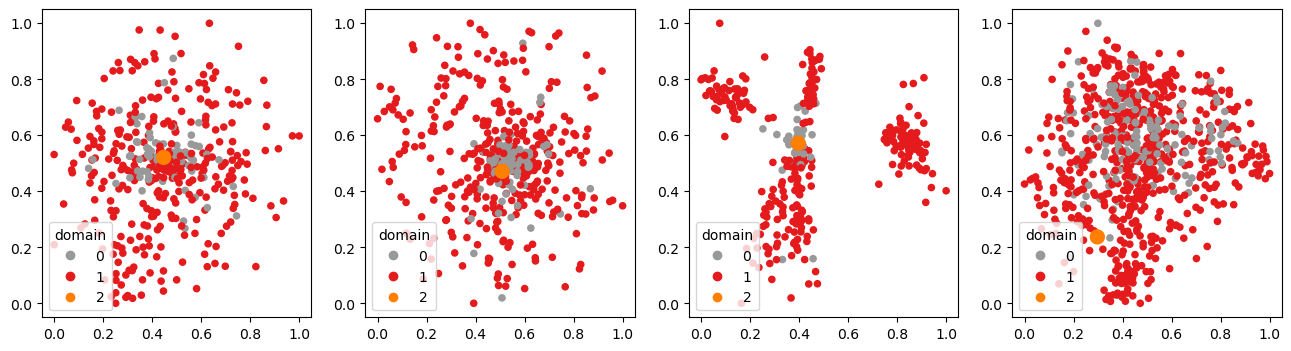

In [64]:
fig, ax  = plt.subplots(1,4,figsize=(16,4))

test_class_result_2D_dict = dict()

for idx, selected_domain in enumerate(domain_to_idx.keys()):
    print(Counter(intermediate_test[selected_domain]["target_list"]))
    perplexity=Counter(intermediate_test[selected_domain]["target_list"])[1]
    early_exaggeration=12
    tsne_2D = TSNE(n_components=2, init='pca', random_state=0, perplexity=perplexity, verbose=1, early_exaggeration=early_exaggeration) #调用TSNE
    class_result_2D = tsne_2D.fit_transform(np.concatenate([intermediate_test[selected_domain]["class_feature_list"], intermediate_train["center"].reshape(1, -1)]))
    test_class_result_2D_dict[selected_domain] = class_result_2D
    
    colors = ['#999999', '#e41a1c', '#ff7f00']
    custom_cmap = ListedColormap(colors)

    x_min, x_max = np.min(class_result_2D, 0), np.max(class_result_2D, 0)
    data = (class_result_2D - x_min) / (x_max - x_min)

    size = np.zeros_like(intermediate_test[selected_domain]["target_list"], dtype=int) + 20
    size = np.append(size, 100)
    scatter = ax[idx].scatter(data[:, 0], data[:, 1], c=np.append(intermediate_test[selected_domain]["target_list"], 2), cmap=custom_cmap, s=size, label = "")
    ax[idx].legend(*(scatter.legend_elements()[0],["normal", "anomaly", "center"]))
    ax[idx].set_title(selected_domain)

plt.savefig(f"../results/intermediate_results/epoch={selected_epochs},test_class_embedding.pdf", format="pdf")

In [70]:
intermediate_test_domain_embedding = []
intermediate_test_domain_labels = []
for item in domain_to_idx.keys():
    intermediate_test_domain_embedding.append(intermediate_test[item]["texture_feature_list"])
    intermediate_test_domain_labels.append(intermediate_test[item]["domain_label_list"])
intermediate_test_domain_embedding = np.concatenate(intermediate_test_domain_embedding)
intermediate_test_domain_labels = np.concatenate(intermediate_test_domain_labels)

In [71]:
print(Counter(intermediate_test_domain_labels))

Counter({3: 784, 1: 466, 0: 407, 2: 331})


In [72]:
perplexity=400
early_exaggeration=12
tsne_2D = TSNE(n_components=2, init='pca', random_state=0, perplexity=perplexity, verbose=1, early_exaggeration=early_exaggeration) #调用TSNE
domain_result_2D = tsne_2D.fit_transform(np.concatenate([intermediate_test_domain_embedding, intermediate_train["domain_prototype"]]))

[t-SNE] Computing 1201 nearest neighbors...
[t-SNE] Indexed 1991 samples in 0.002s...
[t-SNE] Computed neighbors for 1991 samples in 1.180s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1991
[t-SNE] Computed conditional probabilities for sample 1991 / 1991
[t-SNE] Mean sigma: 0.187438
[t-SNE] KL divergence after 250 iterations with early exaggeration: 42.585743
[t-SNE] KL divergence after 1000 iterations: 0.183784


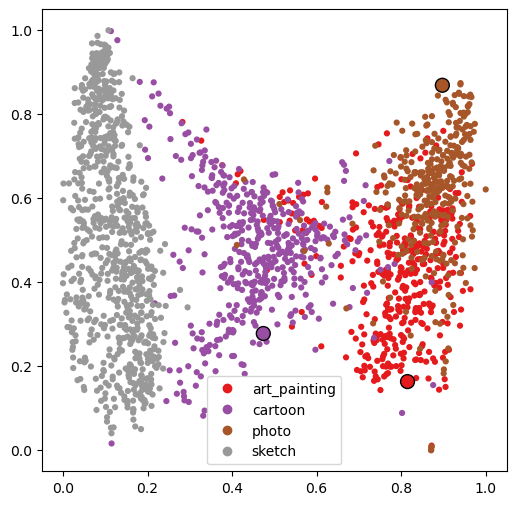

In [125]:
colors = ['#999999', '#e41a1c', '#ff7f00']
custom_cmap = ListedColormap(colors)

x_min, x_max = np.min(domain_result_2D, 0), np.max(domain_result_2D, 0)
data = (domain_result_2D - x_min) / (x_max - x_min)
fig, ax  = plt.subplots(1,1,figsize=(6,6))

size = np.zeros_like(intermediate_test_domain_labels, dtype=int) + 20
size = np.concatenate([size, np.array([100, 100, 100])])
edgecolors = ["none"] * size.shape[0]
edgecolors[-3:] = ["black"] * 3
scatter = ax.scatter(data[:, 0], data[:, 1], c=np.concatenate([intermediate_test_domain_labels, np.array([0,1,2])]), cmap=plt.cm.Set1, s=size, edgecolors=edgecolors)
ax.legend(*(scatter.legend_elements()[0], ['art_painting', 'cartoon', 'photo', 'sketch']))
plt.savefig(f"../results/intermediate_results/epoch={selected_epochs},test_domain_embedding.pdf", format="pdf")

## Init

In [3]:
file_name = 'results/intermediate_results/method9/init_embedding/method=9,backbone=DGAD9,domain_cnt=3,normal_class=[1],anomaly_class=[0, 2, 3, 4, 5, 6],batch_size=30,steps_per_epoch=20,epochs=50,lr=5e-05,origin_svdd_lambda=2.0,class_svdd_lambda=1.0,align_lambda=0.0,beta=0.9,cnt=3.npz'
data = np.load(f"../{file_name}",allow_pickle=True)
feature_list = data["feature_list"]
target_list = data["target_list"]
domain_label_list = data["domain_label_list"]
domain_prototype = data["domain_prototype"]
center = data["center"]

In [4]:
feature_list

array([[-5.1223149e-05,  6.5270783e-03, -3.1247787e-04, ...,
        -7.8285171e-04, -4.8062409e-04, -1.5480745e-04],
       [-3.8430869e-04, -5.0381559e-04,  5.4003268e-02, ...,
        -1.3498211e-03, -1.6094610e-04, -4.7276355e-04],
       [-5.2235904e-04, -2.3923574e-04,  3.5495292e-03, ...,
        -1.6526725e-03, -1.1078379e-05, -2.5821535e-04],
       ...,
       [-4.3258420e-04, -3.0077837e-04,  8.2870185e-02, ...,
        -1.4345087e-03,  1.1280763e-02, -8.3776005e-04],
       [-1.2227334e-04, -5.8289920e-04, -4.0554991e-05, ...,
        -9.5521560e-04,  4.6951015e-02, -6.9504592e-04],
       [ 5.3295433e-03, -2.1826096e-04,  2.5718482e-03, ...,
        -7.4191164e-04,  1.7375262e-02,  6.1341980e-04]], dtype=float32)

In [5]:
Counter(domain_label_list)

Counter({1: 293, 0: 163, 2: 130})

In [6]:
perplexity=200
early_exaggeration=12
tsne_2D = TSNE(n_components=2, init='pca', random_state=0, perplexity=perplexity, verbose=1, early_exaggeration=early_exaggeration) #调用TSNE
class_result_2D = tsne_2D.fit_transform(feature_list)

[t-SNE] Computing 585 nearest neighbors...
[t-SNE] Indexed 586 samples in 0.001s...
[t-SNE] Computed neighbors for 586 samples in 0.264s...
[t-SNE] Computed conditional probabilities for sample 586 / 586
[t-SNE] Mean sigma: 0.067173
[t-SNE] KL divergence after 100 iterations with early exaggeration: 40.887901
[t-SNE] KL divergence after 950 iterations: 0.414144


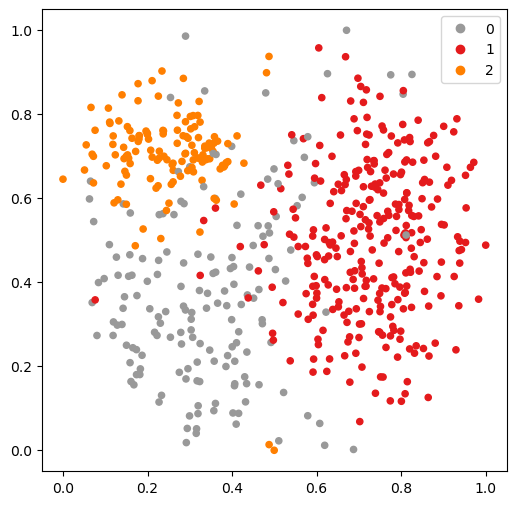

In [7]:
colors = ['#999999', '#e41a1c', '#ff7f00']
custom_cmap = ListedColormap(colors)

x_min, x_max = np.min(class_result_2D, 0), np.max(class_result_2D, 0)
data = (class_result_2D - x_min) / (x_max - x_min)
fig, ax  = plt.subplots(1,1,figsize=(6,6))

scatter = ax.scatter(data[:, 0], data[:, 1], c=domain_label_list, cmap=custom_cmap, s=20)
ax.legend(*(scatter.legend_elements()[0],["0", "1", "2"]))

/home/hzw/anaconda3/envs/general_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/hzw/anaconda3/envs/general_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/hzw/anaconda3/envs/general_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/hzw/anaconda3/envs/general_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarni

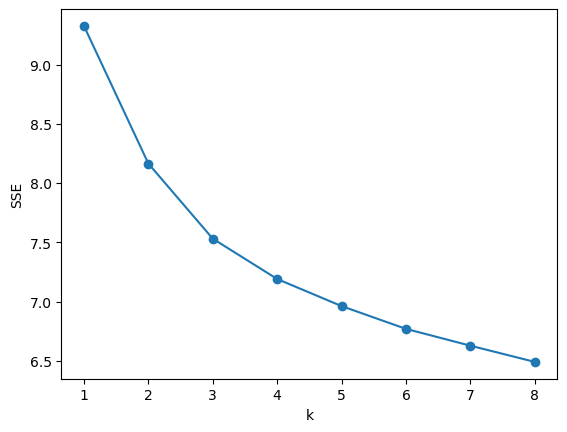

In [8]:
SSE = []  # 存放每次结果的误差平方和
for k in range(1,9):
    estimator = KMeans(n_clusters=k)  # 构造聚类器
    estimator.fit(feature_list)
    SSE.append(estimator.inertia_) # estimator.inertia_获取聚类准则的总和
X = range(1,9)
plt.xlabel('k')
plt.ylabel('SSE')
plt.plot(X,SSE,'o-')
plt.show()

In [9]:
estimator = KMeans(n_clusters=3)  # 构造聚类器
estimator.fit(feature_list)
predict = estimator.predict(feature_list)

/home/hzw/anaconda3/envs/general_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [10]:
Counter(predict)

Counter({1: 300, 2: 151, 0: 135})

In [11]:
Counter(domain_label_list)

Counter({1: 293, 0: 163, 2: 130})

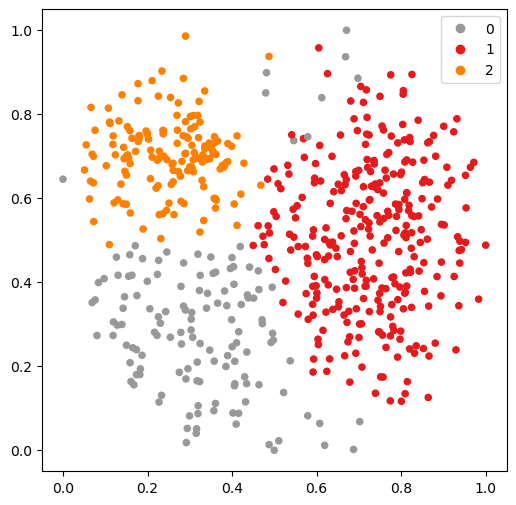

In [12]:
colors = ['#999999', '#e41a1c', '#ff7f00']
custom_cmap = ListedColormap(colors)

x_min, x_max = np.min(class_result_2D, 0), np.max(class_result_2D, 0)
data = (class_result_2D - x_min) / (x_max - x_min)
fig, ax  = plt.subplots(1,1,figsize=(6,6))

scatter = ax.scatter(data[:, 0], data[:, 1], c=predict, cmap=custom_cmap, s=20)
ax.legend(*(scatter.legend_elements()[0],["0", "1", "2"]))

In [ ]:
perplexity=200
early_exaggeration=12
tsne_2D = TSNE(n_components=2, init='pca', random_state=0, perplexity=perplexity, verbose=1, early_exaggeration=early_exaggeration) #调用TSNE
domain_result_2D = tsne_2D.fit_transform(np.concatenate([feature_list, domain_prototype]))
colors = ['#999999', '#e41a1c', '#ff7f00']
custom_cmap = ListedColormap(colors)

x_min, x_max = np.min(domain_result_2D, 0), np.max(domain_result_2D, 0)
data = (domain_result_2D - x_min) / (x_max - x_min)
fig, ax  = plt.subplots(1,1,figsize=(6,6))

size = np.zeros_like(domain_label_list, dtype=int) + 20
size = np.concatenate([size, np.array([100, 100, 100])])
scatter = ax.scatter(data[:, 0], data[:, 1], c=np.concatenate([domain_label_list, np.array([0,1,2])]), cmap=plt.cm.Set1, s=size)
ax.legend(*(scatter.legend_elements()[0], ['art_painting', 'cartoon', 'photo']))